In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from IPython.display import clear_output 

In [3]:
#Importing the dataset 

#number of individual 
n_obs = 12
#PVC total count 
PVC_tot = np.array([11, 11, 17, 22, 9, 6, 5, 14, 9, 7, 22, 51])

#before drugs 
before_drugs = np.array([6, 9, 17, 22, 7, 5, 5, 14, 9, 7, 9, 51])

#after drugs 
after_drugs = np.array([5, 2, 0, 0, 2, 1, 0, 0, 0, 0, 13, 0])

hearts = np.vstack((PVC_tot, before_drugs, after_drugs))
hearts = hearts.T
print("---------------------------------------------")
print(pd.DataFrame(hearts, columns = ["PVC_tot", "before_drugs", "after_drugs"]))

---------------------------------------------
    PVC_tot  before_drugs  after_drugs
0        11             6            5
1        11             9            2
2        17            17            0
3        22            22            0
4         9             7            2
5         6             5            1
6         5             5            0
7        14            14            0
8         9             9            0
9         7             7            0
10       22             9           13
11       51            51            0


In [32]:
def Gibbs(nchain, data, sd_alpha, sd_delta, init, sigma_alpha, sigma_delta, burning, lag= 10):
    #init
    chain = np.zeros((nchain+1,2)) #alpha, delta 
    chain[0] = init
    
    #observation
    tot = data[:, 0]
    before  = data[:, 1]
    after = data[:, 2]
    N = len(tot)
    ########
    prob_accep = 0
    
    for i in range(nchain):
        ######### MAJ alpha ############
        new_candidate = chain[i, 0] + np.random.normal(scale= sd_alpha)
        
        top = -(new_candidate**2 / (2*sigma_alpha**2)) \
            + (np.log(np.exp(chain[i, 1])+(1+np.exp(new_candidate))**(-tot * (after == 0)))).sum() \
                + (new_candidate*(after * (after != 0))).sum() - np.log(1+np.exp(new_candidate))*(tot * (after !=0)).sum()
            
        bottom = -(chain[i, 0]**2 / (2*sigma_alpha**2))   \
            + (np.log(np.exp(chain[i, 1])+(1+np.exp(chain[i, 0]))**(-tot * (after == 0)))).sum() \
                + (chain[i, 0]*(after * (after != 0))).sum() - np.log(1+np.exp(chain[i,0]))*(tot * (after !=0)).sum()
        ratio = top -bottom

        
        u = np.log(np.random.uniform())
        if u < ratio :
            chain[i+1, 0] = new_candidate
            prob_accep += 1
        else:
            chain[i+1, 0] = chain[i, 0]
        
        ############## MAJ delta ################# 
        new_candidate = chain[i, 1] + np.random.normal(scale= sd_delta)
        
        top = -(new_candidate**2 / (2* sigma_delta**2)) - N * np.log(1+np.exp(new_candidate)) \
            + np.sum(np.log(np.exp(new_candidate) + (1+np.exp(chain[i+1, 0]))**(-tot * (after == 0))))
        
            
        bottom = -(chain[i, 1]**2 / (2*sigma_delta**2)) - N * np.log(1+np.exp(chain[i, 1])) \
            + np.sum(np.log(np.exp(chain[i, 1]) + (1+np.exp(chain[i+1, 0]))**(-tot * (after == 0)) ))
        
        ratio = top - bottom
        #print(ratio)
        u = np.log(np.random.uniform())
        if u < ratio :
            chain[i+1, 1] = new_candidate
            prob_accep += 1
        else:
            chain[i+1, 1] = chain[i, 1]
    #####################
        if i % 100 == 0:
            clear_output(wait = True)
            print(f"Iteration : {i}")
        
    #burning and lag 
    index_simu = np.arange(burning, nchain+1, lag)
    chain = chain[index_simu, :]
    
    return chain, prob_accep/(2*nchain)
    
        
        
    

In [33]:
simu, accep = Gibbs(21000, hearts, 3, 1, np.array([0,0]), 1000, 1000, 11000)

Iteration : 20900


In [34]:
accep

0.5521904761904762

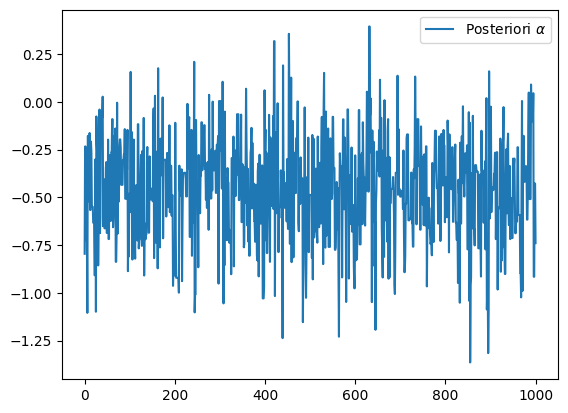

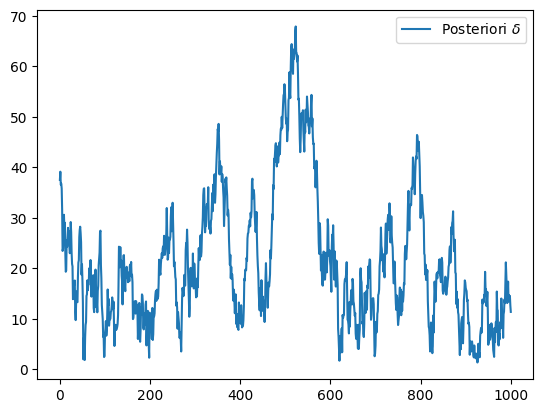

In [26]:
plt.plot(simu[:, 0], label = r'Posteriori $\alpha$');
plt.legend()
plt.show()
plt.plot(simu[:, 1], label = r'Posteriori $\delta$');
plt.legend();